In [1]:
# std
import os
import sys
import inspect
import time
import pathlib
from math import sqrt
from math import log2
# packgaes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

# packages
from matplotlib.colors import ListedColormap

## sklearn
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import median_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# for selection the right path
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common.DataParser import parse_moneyball
from common.model_trainer_reg import *
from common.regression_plotfunctions import *

from GD.LinearRegression import LinearRegression
from KNN.KNNRegressor import KNNRegressor

In [2]:
df_raw = parse_moneyball()

df_raw

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


# Data explenarision

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


In [13]:
(1976 + 1624)*100 / (1232*15)  #extimated percentage of missing values

19.48051948051948

# Description of data columns

RS ... Runs Scored, 

RA ... Runs Allowed

***RD ... Run differential (actually difference)***

W ... Wins

OBP ... On-Base Percentage

SLG ... Slugging Percentage

BA ... Batting Average

Playoffs (binary)

RankSeason

RankPlayoffs

G ... Games Played

OOBP ... Opponent On-Base Percentage

OSLG ... Opponent Slugging Percentage

In [6]:
cols_to_drop = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
df_prep = df_raw.drop(cols_to_drop, axis=1)

# Fix missing values and type
df_prep.replace("?",0, inplace=True)
#df_prep = df_prep[df_prep.OOBP != 0]
df_prep[['OOBP','OSLG']] = df_prep[['OOBP','OSLG']].astype(float)

df_prep

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,NaN,NaN
1228,706,626,93,0.321,0.394,0.268,161,NaN,NaN
1229,878,690,103,0.341,0.441,0.278,165,NaN,NaN
1230,774,664,84,0.335,0.394,0.271,163,NaN,NaN


# Handling missingvalues

420 Nan values are in the OOBP and OSLG column.

1) Stategie is to drop these rows with the Nan values. The impact of this stategie is that the dataset shrinks.

2) calculate the mean value from all other values in the column and replace it with it.

In [7]:
r_mean = np.mean(df_prep["OOBP"])
print(r_mean)
df_prep_mean = df_prep
df_prep_mean["OOBP"] = df_prep["OOBP"].replace(float('NaN'),r_mean)
r_mean = np.mean(df_prep["OSLG"])
print(r_mean)
df_prep_mean  = df_prep_mean.replace(float('NaN'),r_mean)

df_prep_mean

0.3322642857142857
0.41974285714285714


,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317000,0.415000
1,700,600,94,0.320,0.389,0.247,162,0.306000,0.378000
2,712,705,93,0.311,0.417,0.247,162,0.315000,0.403000
3,734,806,69,0.315,0.415,0.260,162,0.331000,0.428000
4,613,759,61,0.302,0.378,0.240,162,0.335000,0.424000
...,...,...,...,...,...,...,...,...,...
1227,705,759,81,0.330,0.390,0.260,161,0.332264,0.419743
1228,706,626,93,0.321,0.394,0.268,161,0.332264,0.419743
1229,878,690,103,0.341,0.441,0.278,165,0.332264,0.419743
1230,774,664,84,0.335,0.394,0.271,163,0.332264,0.419743


In [8]:
df_prep_nomiss = df_prep.dropna()
df_prep_nomiss

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
415,872,831,86,0.356,0.434,0.271,162,0.345,0.423
416,809,838,75,0.338,0.426,0.262,161,0.355,0.427
417,772,913,69,0.343,0.411,0.274,162,0.371,0.448
418,945,859,95,0.361,0.479,0.293,162,0.346,0.459


# Distributions from the taget-clomum

In [9]:
mean = np.mean(df_prep_nomiss["W"])
mean

80.95714285714286

80.95714285714286


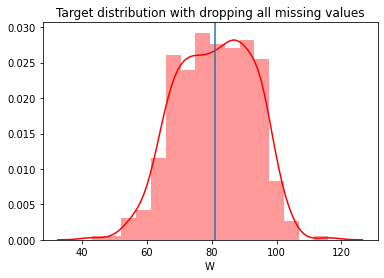

In [14]:
print(np.mean(df_prep_nomiss["W"]))
plot = sns.distplot(df_prep_nomiss["W"], color="red")
plt.title("Target distribution with dropping all missing values")
plt.axvline(mean)
plt.savefig("out/explornation/nomiss.png")

80.90422077922078


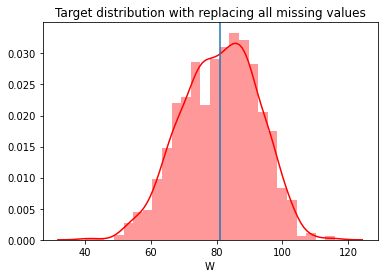

In [15]:
print(np.mean(df_prep_mean["W"]))
sns.distplot(df_prep_mean["W"], color="red")
plt.title("Target distribution with replacing all missing values")
plt.axvline(mean)
plt.savefig("out/explornation/mean.png")

Both "look" similar to a normal distribution density (i.e. Gauß) -> regression should work well!